In [1]:
#set adequate flag for Theano on lxplus
import theano
theano.config.gcc.cxxflags = '-march=corei7'

In [2]:
#check config
import keras.backend as K
K.set_image_dim_ordering('th')
#print 'Keras backend:', K.backend()
#print 'Keras image ordering operator: ', K.image_dim_ordering()

Using Theano backend.


In [3]:
#load needed things
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import ROOT
import itertools
import math

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Welcome to JupyROOT 6.07/07


In [4]:
#format the inputs from TTree
# 4D tensor (theano backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is props value (pt, charge, pdgId, etc.)
def formatInputs(files):
    quark_jets = []#type 1
    gluon_jets = []#type 0

    for ifile in files:
        tree = ifile.Get('JetImage')
            
        for ievt, evt in enumerate(tree):            
            #get PFJets
            nPFJets = evt.PFJetEta.size()
            for iPFJet in range(nPFJets):
                pfJetDistance = evt.PFJetDistance[iPFJet]
                pfjet = []
                pt  = []
                eta = []
                phi = []
                e = []
                charge = []
                pdgId = []
                    
                #get daughters
                nDaughters = evt.SubJetEta[iPFJet].size()
                for iDau in range(nDaughters):
                    pt.append( evt.SubJetPt[iPFJet][iDau] )
                    eta.append( evt.SubJetEta[iPFJet][iDau] )
                    phi.append( evt.SubJetPhi[iPFJet][iDau] )
                    e.append( evt.SubJetE[iPFJet][iDau] )
                    charge.append( evt.SubJetCharge[iPFJet][iDau] )
                    pdgId.append( evt.SubJetPDGID[iPFJet][iDau] )
                
                #creates the vector of pfjets properties
                pfjet.append(pfJetDistance)
                pfjet.append(pt)
                pfjet.append(eta)
                pfjet.append(phi)
                pfjet.append(e)
                pfjet.append(charge)
                pfjet.append(pdgId)
                
                #decides if quark or gluon jet
                if evt.PFJetType[iPFJet] == 1:
                    quark_jets.append(pfjet)
                if evt.PFJetType[iPFJet] == 0:
                    gluon_jets.append(pfjet)
                    
    return quark_jets, gluon_jets

In [5]:
#loads input data
vbf_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/VBF_HToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
ggh_inputs = ROOT.TFile.Open('/afs/cern.ch/work/m/mmelodea/private/MonoHiggs/CMSSW_9_0_0/src/JetImageFiles/GluGluHToZZTo4L_M125_13TeV_powheg2_JHUgenV6_pythia8.root')
inputs = [vbf_inputs,ggh_inputs]

#format tree inputs to adequate shape
quark_jets, gluon_jets = formatInputs(inputs)
print 'quark jets: %i' % len(quark_jets)
print 'gluon jets: %i' % len(gluon_jets)

quark jets: 132654
gluon jets: 16188


In [37]:
#filter events based on DR(eta,phi)
maxDr = 0.4 #jet radius - ak4PFJetCHS
fquark_jets = []
fgluon_jets = []

for ijet in quark_jets:
    if(ijet[0] < maxDr):
        fquark_jets.append(ijet)
        
for ijet in gluon_jets:
    if(ijet[0] < maxDr):
        fgluon_jets.append(ijet)
        
maxjets = min(len(fquark_jets),len(fgluon_jets))
fquark_jets = [fquark_jets[i] for i in range(maxjets)]
fgluon_jets = [fgluon_jets[i] for i in range(maxjets)]
print 'quark jets: %i (%.2f)' % (len(fquark_jets),len(fquark_jets)/float(len(quark_jets)))
print 'gluon jets: %i (%.2f)' % (len(fgluon_jets),len(fgluon_jets)/float(len(gluon_jets)))

quark jets: 8370 (0.06)
gluon jets: 8370 (0.52)


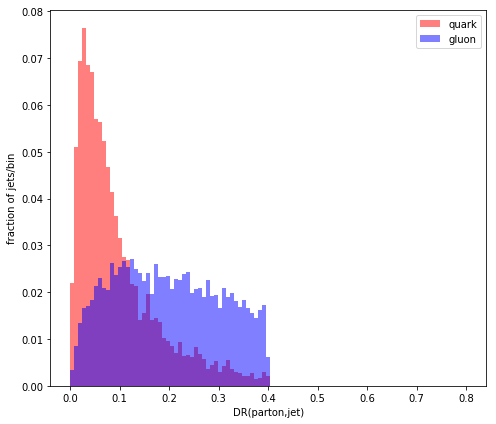

In [38]:
#checking jet distance to hard scattering parton
qjets_dr = []
qweights = []
gjets_dr = []
gweights = []

njets = len(fquark_jets)
for iqj in range(njets):
    qjets_dr.append(fquark_jets[iqj][0])
    qweights.append(1./njets)
    
njets = len(fgluon_jets)    
for igj in range(njets):
    gjets_dr.append(fgluon_jets[igj][0])
    gweights.append(1./njets)

fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(7)

bins = np.linspace(0, 0.8, 100)
fig = pyp.hist(qjets_dr, bins, weights=qweights, alpha=0.5, color='red', label='quark')
fig = pyp.hist(gjets_dr, bins, weights=gweights, alpha=0.5, color='blue',label='gluon')
fig = pyp.xlabel('DR(parton,jet)')
fig = pyp.ylabel('fraction of jets/bin')
pyp.legend(loc='upper right')
#pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

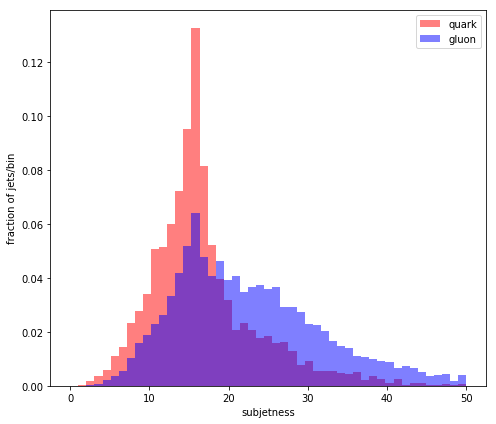

In [39]:
#checking jet constituents multiplicity
qjets_subjetness = []
qweights = []
gjets_subjetness = []
gweights = []

njets = len(fquark_jets)
for iqj in range(njets):
    qjets_subjetness.append(len(fquark_jets[iqj][1]))
    qweights.append(1./njets)

njets = len(fgluon_jets)
for igj in range(njets):
    gjets_subjetness.append(len(fgluon_jets[igj][1]))
    gweights.append(1./njets)

fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(7)

bins = np.linspace(0, 50, 50)
fig = pyp.hist(qjets_subjetness, bins, weights=qweights, alpha=0.5, color='red', label='quark')
fig = pyp.hist(gjets_subjetness, bins, weights=gweights, alpha=0.5, color='blue',label='gluon')
fig = pyp.xlabel('subjetness')
fig = pyp.ylabel('fraction of jets/bin')
pyp.legend(loc='upper right')
#pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

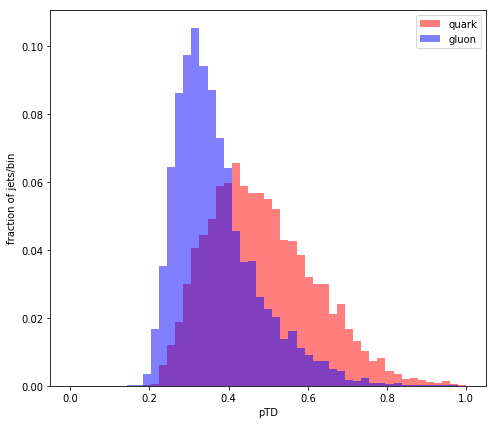

In [40]:
#checking jet energy distribution over constituents
qjets_ptD = []
gjets_ptD = []

njets = len(fquark_jets)
for iqj in range(njets):
    sum_pt = 0
    sum_pt2 = 0
    for iiqj in range(len(fquark_jets[iqj][1])):
        sum_pt += fquark_jets[iqj][1][iiqj]
        sum_pt2 += math.pow(fquark_jets[iqj][1][iiqj],2)
    ptD = math.sqrt(sum_pt2)/sum_pt
    qjets_ptD.append(ptD)

njets = len(fgluon_jets)
for igj in range(njets):
    sum_pt = 0
    sum_pt2 = 0
    for iigj in range(len(fgluon_jets[igj][1])):
        sum_pt += fgluon_jets[igj][1][iigj]
        sum_pt2 += math.pow(fgluon_jets[igj][1][iigj],2)
    ptD = math.sqrt(sum_pt2)/sum_pt
    gjets_ptD.append(ptD)
    

fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(7)

bins = np.linspace(0, 1, 50)
fig = pyp.hist(qjets_ptD, bins, weights=qweights, alpha=0.5, color='red', label='quark')
fig = pyp.hist(gjets_ptD, bins, weights=gweights, alpha=0.5, color='blue',label='gluon')
fig = pyp.xlabel('pTD')
fig = pyp.ylabel('fraction of jets/bin')
pyp.legend(loc='upper right')
#pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

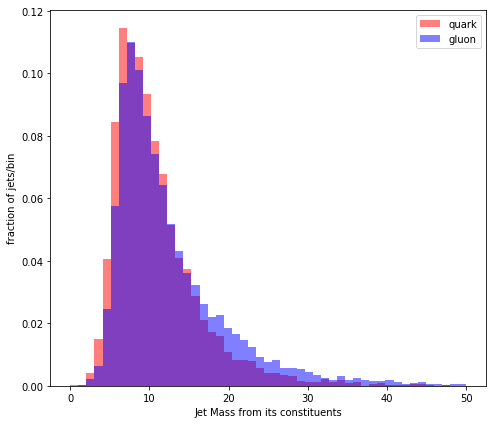

In [41]:
#checking jets mass
qjets_mass = []
gjets_mass = []

for iqj in fquark_jets:
    p4qjet = ROOT.TLorentzVector()
    p4qjet.SetPtEtaPhiE(0,0,0,0)
    p4qsjet = ROOT.TLorentzVector()
    for iiqj in range(len(iqj[1])):
        p4qsjet.SetPtEtaPhiE(iqj[1][iiqj],iqj[2][iiqj],iqj[3][iiqj],iqj[4][iiqj])
        p4qjet += p4qsjet
    qjets_mass.append(p4qjet.M())
        
for igj in fgluon_jets:
    p4gjet = ROOT.TLorentzVector()
    p4gjet.SetPtEtaPhiE(0,0,0,0)
    p4gsjet = ROOT.TLorentzVector()
    for iigj in range(len(igj[1])):
        p4gsjet.SetPtEtaPhiE(igj[1][iigj],igj[2][iigj],igj[3][iigj],igj[4][iigj])
        p4gjet += p4gsjet
    gjets_mass.append(p4gjet.M())

fig = pyp.figure()
fig.set_figheight(6)
fig.set_figwidth(7)

bins = np.linspace(0, 50, 50)
fig = pyp.hist(qjets_mass, bins, weights=qweights, alpha=0.5, color='red', label='quark')
fig = pyp.hist(gjets_mass, bins, weights=gweights, alpha=0.5, color='blue', label='gluon')
fig = pyp.xlabel('Jet Mass from its constituents')
fig = pyp.ylabel('fraction of jets/bin')
pyp.legend(loc='upper right')
#pyp.gca().set_yscale("log")

pyp.tight_layout()
fig = pyp.show()

In [42]:
#shifts the subjets towards the 1st PFJet based on the highest pt subjet
#eta'_i = eta_i - eta_0
#phi'_i = phi_i - phi_0
def translate(etas, phis, pts):
    xShift = []
    yShift = []
    
    #center based on 1st hardest subPFJet
    index = np.argmax(pts)
    xCenter = etas[index]
    yCenter = phis[index]
    
    #etas and phis from subjets from 1st PFJet
    for ix, iy in zip(etas, phis):
        xShift.append( ix - xCenter )
        yShift.append( iy - yCenter )
    
    return np.array(xShift), np.array(yShift)

In [43]:
#rotation not applied directly on eta-phi plane to preserve Lorentz invariances
#the rotation is likely done around px
def rotate(etas, phis, pts):
    #finds a second hardest subPFJet to rotate towards the 1st subPFjet
    index = np.argmax(pts)
    xCenter = etas[index]
    yCenter = phis[index]
    maxPt = -1
    v = 0
    for ix, iy, ip in zip(etas, phis, pts):
        dv = np.matrix([[ix],[iy]])-np.matrix([[xCenter],[yCenter]])
        dR = np.linalg.norm(dv)
        if(dR > 0.2 and ip > maxPt):
            maxPt = ip
            py = ip*math.sin(iy)
            pz = ip*math.sinh(ix)
            #computes the rotation angle
            v = np.arctan2(py,pz) + np.radians(90)

    rot_x = []
    rot_y = []
    #creates a rotation matrix
    c, s = np.cos(v), np.sin(v)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))

    for ix, iy, iw in zip(etas, phis, pts):
        #original components
        py = iw*math.sin(iy)
        pz = iw*math.sinh(ix)

        #transforms components
        rot = R*np.matrix([[py],[pz]])
        rix, riy = np.arcsinh(rot[1,0]/iw), np.arcsin(rot[0,0]/iw)
        
        rot_x.append(rix)
        rot_y.append(riy)
        
    return np.array(rot_x), np.array(rot_y)

In [44]:
#accounts for assymetry on energy distribution
#keeps the jet average pt always in eta' positive range
def reflect(etas, pts):
    leftSum = 0
    rightSum = 0
    for ix, iw in zip(etas, pts):
        if ix > 0: 
            rightSum += iw
        elif ix < 0:
            leftSum += iw
                        
    if(leftSum > rightSum):
        ref_x = [e*(-1) for e in etas]
        return np.array(ref_x)
    else:
        return np.array(etas)

In [45]:
#nx size of image in eta
#ny size of image in phi
def prepareImages(jets, nx, xmin, xmax, ny, ymin, ymax, pre_process):
    njets = len(jets)
    #njets = 1
    
    list_x = []
    list_y = []
    list_w = []

    #determines the pixel of picture
    xbins = np.linspace(xmin,xmax,nx+1)
    ybins = np.linspace(ymin,ymax,ny+1)
    
    #creates an empty 'th2'
    jet_images = np.zeros((njets, 1, nx, ny))

    #loop over jets
    for ijet in range(njets):
        #get vars
        pts = jets[ijet][1]
        etas = jets[ijet][2]
        phis = jets[ijet][3]
        energies = jets[ijet][4]
        charges = jets[ijet][5]
        pdgIds = jets[ijet][6]
        
        #shifts the jet image to the center in (eta,phi) = (0,0)
        if(pre_process[0]):
            etas, phis = translate(etas, phis, pts)

        #applies the rotation processing
        if(pre_process[1]):
            etas, phis = rotate(etas, phis, pts)
                        
        #applies the reflection processing
        if(pre_process[2]):
            etas = reflect(etas, pts)

        #applies normalization
        if(pre_process[3]):
            sumPt = sum(pts)
            pts = [ip/sumPt for ip in pts]

        x = etas
        y = phis
        weights = pts
        list_x.append(x)
        list_y.append(y)
        list_w.append(weights)
        hist, xedges, yedges = np.histogram2d(x, y, weights=weights, bins=(xbins, ybins))
        for ix in range(0,nx):
            for iy in range(0,ny):
                jet_images[ijet,0,ix,iy] = hist[ix,iy]

                                        
    return jet_images, list_x, list_y, list_w, xbins, ybins

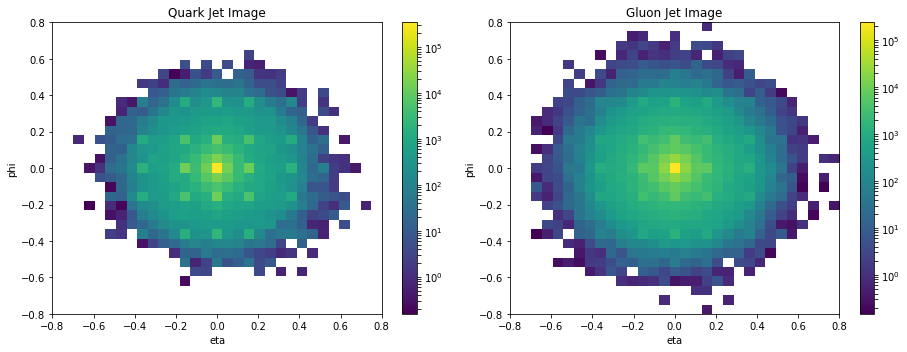

In [46]:
#chose amount of pixels
nx = 31
xmin = -0.8
xmax = 0.8
ny = 31
ymin = -0.8
ymax = 0.8
proc = [True,False,False,False]

#create and show jet images
qjet_images, qlist_x, qlist_y, qlist_w, qxbins, qybins = prepareImages(fquark_jets, nx, xmin, xmax, ny, ymin, ymax, proc)

qall_x = np.concatenate(qlist_x)
qall_y = np.concatenate(qlist_y)
qall_w = np.concatenate(qlist_w)
#qall_w = 1.*qall_w/len(qjet_images) # to get average

gjet_images, glist_x, glist_y, glist_w, gxbins, gybins = prepareImages(fgluon_jets, nx, xmin, xmax, ny, ymin, ymax, proc)

gall_x = np.concatenate(glist_x)
gall_y = np.concatenate(glist_y)
gall_w = np.concatenate(glist_w)
#gall_w = 1.*gall_w/len(gjet_images) # to get average

fig = pyp.figure()
fig.set_figheight(5)
fig.set_figwidth(13)

fig1 = fig.add_subplot(121)
fig1 = pyp.hist2d(qall_x, qall_y, weights=qall_w, bins=(qxbins,qybins), norm=mpl.colors.LogNorm())
fig1 = pyp.colorbar()
fig1 = pyp.xlabel('eta')
fig1 = pyp.ylabel('phi')
fig1 = pyp.title('Quark Jet Image')

fig2 = fig.add_subplot(122)
fig2 = pyp.hist2d(gall_x, gall_y, weights=gall_w, bins=(gxbins,gybins), norm=mpl.colors.LogNorm())
fig2 = pyp.colorbar()
fig2 = pyp.xlabel('eta')
fig2 = pyp.ylabel('phi')
fig2 = pyp.title('Gluon Jet Image')

pyp.tight_layout()
fig = pyp.show()

In [47]:
from keras.layers import AveragePooling2D

# Model
def build_conv_model():
    input_layer = Input(shape=(1, nx, ny))
    layer = Convolution2D(8, 20, 20, border_mode='same')(input_layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Convolution2D(8, 20, 20, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Convolution2D(8, 20, 20, border_mode='same')(layer)
    layer = Activation('tanh')(layer)
    layer = MaxPooling2D(pool_size=(3,3))(layer)
    layer = Flatten()(layer)
    layer = Dropout(0.20)(layer)
    layer = Dense(20)(layer)
    layer = Dropout(0.10)(layer)
    output_layer = Dense(1, activation='sigmoid')(layer)
    model = Model(input=input_layer, output=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

conv_model = build_conv_model()
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 31, 31)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 31, 31)         3208      
_________________________________________________________________
activation_34 (Activation)   (None, 8, 31, 31)         0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 8, 10, 10)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 10, 10)         25608     
_________________________________________________________________
activation_35 (Activation)   (None, 8, 10, 10)         0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 8, 3, 3)           0         
__________

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (20, 20), padding="same")`
  
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (20, 20), padding="same")`
  if __name__ == '__main__':
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (20, 20), padding="same")`
  if sys.path[0] == '':
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_12)`


In [48]:
#prepare inputs for model
X = np.concatenate([qjet_images, gjet_images])
qY = np.ones(qjet_images.shape[0])
gY = np.zeros(gjet_images.shape[0])
Y = np.concatenate([qY, gY])

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

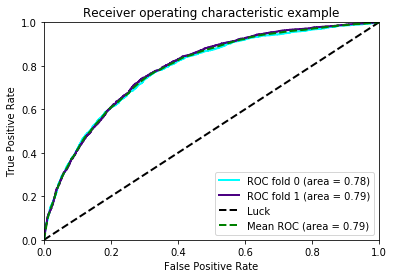

Train on 8370 samples, validate on 8370 samples
Epoch 1/10
302s - loss: 0.6240 - acc: 0.6493 - val_loss: 0.5755 - val_acc: 0.7091
Epoch 2/10
304s - loss: 0.5854 - acc: 0.7025 - val_loss: 0.5875 - val_acc: 0.6950
Epoch 3/10
303s - loss: 0.5714 - acc: 0.7139 - val_loss: 0.5789 - val_acc: 0.7022
Epoch 4/10
305s - loss: 0.5647 - acc: 0.7207 - val_loss: 0.5675 - val_acc: 0.7094
Epoch 5/10
305s - loss: 0.5560 - acc: 0.7251 - val_loss: 0.5813 - val_acc: 0.7041
Epoch 6/10
304s - loss: 0.5443 - acc: 0.7302 - val_loss: 0.5727 - val_acc: 0.7086
Epoch 7/10
309s - loss: 0.5357 - acc: 0.7369 - val_loss: 0.5664 - val_acc: 0.7183
Epoch 8/10
316s - loss: 0.5279 - acc: 0.7425 - val_loss: 0.5622 - val_acc: 0.7196
Epoch 9/10
311s - loss: 0.5117 - acc: 0.7526 - val_loss: 0.5666 - val_acc: 0.7164
Epoch 10/10
316s - loss: 0.4854 - acc: 0.7761 - val_loss: 0.5664 - val_acc: 0.7115
Train on 8370 samples, validate on 8370 samples
Epoch 1/10
306s - loss: 0.6345 - acc: 0.6535 - val_loss: 0.5844 - val_acc: 0.6992
E

/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (20, 20), padding="same")`
  
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (20, 20), padding="same")`
  if __name__ == '__main__':
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (20, 20), padding="same")`
  if sys.path[0] == '':
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_13)`
/afs/cern.ch/user/m/mmelodea/keras/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=sigmoid.0, inputs=/input_14)`


In [49]:
# Train and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    conv_model = build_conv_model()
    history = conv_model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), epochs=10, batch_size=128, verbose=2, callbacks=[early_stopping])
    Y_score = conv_model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    pyp.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
pyp.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
pyp.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
pyp.xlim([0, 1.0])
pyp.ylim([0, 1.0])
pyp.xlabel('False Positive Rate')
pyp.ylabel('True Positive Rate')
pyp.title('Receiver operating characteristic example')
pyp.legend(loc="lower right")
pyp.show()

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    #x *= 255
    if K.image_dim_ordering()=='tf':
        x = x.transpose((1, 2, 0))
        x = x.transpose((1, 0, 2))
    #x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# dimensions of the generated pictures for each filter.
img_width = nx
img_height = ny

layer_dict = dict([(layer.name, layer) for layer in conv_model.layers])
input_img = conv_model.input

pics = {}
num_filters = {}
for key, layer in layer_dict.iteritems():
    #if 'convolution2d' in key:
    if 'conv2d' in key:
        num_filters[key] = 8
        
layer_name = num_filters.keys()[1]

print num_filters.keys()
print layer_name # here we pick which layer to visualize

In [ ]:
kept_filters = []
for filter_index in range(0,num_filters[layer_name]):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering()=='tf':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    
    if K.image_dim_ordering()=='tf':
        input_img_data = np.random.random((1, img_width, img_height, 1))
    else:
        input_img_data = np.random.random((1, 1, img_width, img_height))
        
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 100 steps
    for i in range(100):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    # decode the resulting input image
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    
fig = pyp.figure(figsize=(15,15))
i = 0
j = 0
for img, loss  in kept_filters:
    i+=1
    fig.add_subplot(3,3,i)
    pyp.imshow(img[0])
    #pyp.colorbar()
    
pyp.tight_layout()
fig = pyp.show()